# **ECS659U/P Coursework**


## Setting up Colab & Python Modules
Connect to Google Drive and import the necessary python modules as well as my_utils which was given in the labs

In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

# Importing modules
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
import my_utils as mu # Uploaded to google drive (from labs)

Mounted at /content/gdrive


## The Dataset

### Dataloaders
Defining a function that downloads a batch of training and test data from the torchvision Fashion-MNIST dataset.


In [2]:
# Download the Fashion-MNIST dataset and then load it into memory

def fashion_mnist_dataset(train_batch_size, test_batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, train_batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, test_batch_size, shuffle=False,
                            num_workers=4))

### Loading the data

Specify batch size to download from the torchvision library, with the variable `batch_size`. Then run the load function to acquire the data.

In [3]:
test_batch_size = 256
train_batch_size = 256
train_iter, test_iter = fashion_mnist_dataset(train_batch_size, test_batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Split training data into pytorch tensors $X$ and $y$. 

The first tensor, $X$ is a pytorch tensor of the dimensions $256 \times 1 \times 28 \times 28$ where:
`256` is the number of images in the dataset (`batch_size`). `1` represents the channel dimension of the image. The first `28` represents the height `H` of the image. The second `28` represents the width `W` of the image.

The second tensor, `y` is the true label vector of the images, represented by integers ranging from 0-9. `y` is a pytorch tensor vector of dimension `256`. The class-representation of `y` values are as follows:

| Label    | Classification    |
|---------:|:------------------|
| 0        | T-shirt/top       |
| 1        | Trouser           | 
| 2        | Pullover          |
| 3        | Dress             |
| 4        | Coat              |
| 5        | Sandal            |
| 6        | Shirt             |
| 7        | Sneaker           |
| 8        | Bag               |
| 9        | Ankle boot        |



In [4]:
# First batch
X, y = next(iter(train_iter))
print(X.size())
print(y.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 28, 28])
torch.Size([256])


Visualizing the first image

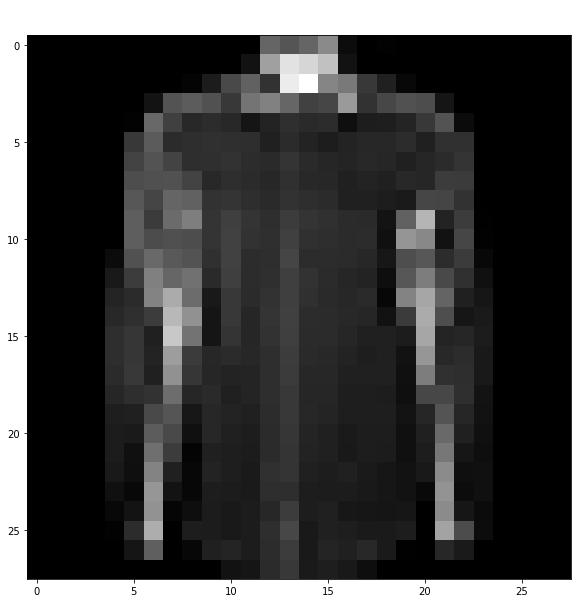

In [5]:
# Get first image and remove channel dimension
x = X[0]
x = x.squeeze(dim=0)

# Get true class/label of first image
label = y.numpy()[0]
label_classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"]

# Plot image
fig1 = plt.figure(figsize=(10,10));
fig1.tight_layout()
plt.title(f"True class: {label_classes[int(label)]}", fontsize = 30, color='w')
plt.imshow(x.numpy(), cmap='gray')
plt.show()

## Image Patching

Splitting the image into non-overlapping patches. This will occur in the "Stem" stage of the model.The patching function must meet the following criteria:

Each image of $H \times W = 28 \times 28$ will be split into $N_p$ non-overlapping patches. Each patch, $p_{i,j}$ will be of the dimensions $k \times k$. *The patch length, $k$ must be a multiple of the image dimensions; $28 \times 28$*. Once the patches are loaded, they must be vectorized into a feature vector of dimension $d$, where $d = k \times k$. This results in an input vector, $X$ being transformed into a matrix with the dimensions (`batch_size`, $N_p$, $d$)



### Visualizing patched image 
Visualizing the first image with the patching method

`patch_width` of size ($k=14$) is used. Then calculated the `patch_number` ($N_p$) from the size of the patches. 

Split the $28 \times 28$ image into four $14 \times 14$ patches. 

When the patches are flattened, it results to an image vector of size $4 \times 14 \times 14$.

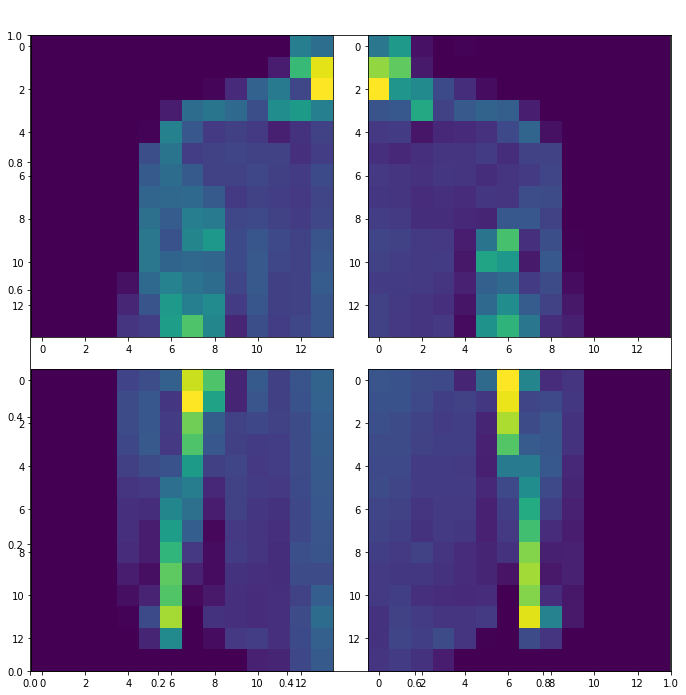

In [6]:
# First image
input_image = X[0]

# Define patch width
# This is the value k in specifications
patch_width = 14

# Get number of patches an image will contain
# This is N_p in specifications
patch_number = (28 // patch_width) ** 2

# Convert image into patches
patches = input_image.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
patch = patches[0].reshape([-1, 14, 14])

# Plot each of the patches
fig = plt.figure(figsize=(10,10));
plt.title(f"True class: {label_classes[int(label)]}", fontsize = 30, color='w')
columns = 28//patch_width;
rows = 28//patch_width;
for i in range(len(patch)):
    fig.add_subplot(rows, columns, i+1)
    fig.tight_layout()
    plt.imshow(patch[i].numpy())
plt.show()

### The Patching Function
Constructing patching function, that returns the vectorized patches for each image.

> For a patch size of `patch_width = 14`, $N_p = 4$ vectors of length $14 \times 14 = 196$.




In [7]:
def patchifier(input_images, patch_width):

  # Get number of patches an image will contain
  patch_number = (28 // patch_width) ** 2
  # Convert image into patches
  patches = input_images.unfold(1, patch_width, patch_width).unfold(2, patch_width, patch_width)
  # Vectorize patches
  patches = patches.reshape([input_images.size(dim=0), patch_number, patch_width**2])

  return patches

## The Model

The model consists of 3 stages:

### 1. The Stem
The stem stage of the model first takes the model inputs, and removes the channel dimension. This results with a matrix with the dimensions `x.size = (256,28,28)`. From here, `x` is then passed to the patchifier function.

### 2. The Backbone
In this model, a backbone with $N = 2$ blocks was chosen, as through testing more blocks, the use of a two-block setup was found to provide the highest accuracy

### 3. The Classifier
The classifier stage of the model

In [8]:
class NeuralNet(torch.nn.Module):
    def __init__(self, patch_size, input, output1, output2, output3, output4, output5, output6, output7, output8, output9, output10, classes):
        super(NeuralNet, self).__init__()
        self.patch_size = patch_size
        self.input = input
        self.output1 = output1
        self.output2 = output2
        self.output3 = output3
        self.output4 = output4
        self.output5 = output5
        self.output6 = output6
        self.output8 = output8
        self.output9 = output9
        self.output10 = output10
        self.classes = classes

        ##### STEM SETUP #####
        self.StemLinear = nn.Linear(input, output1)
        self.ReLU0 = nn.ReLU()

        ##### BACKBONE SETUP #####

        #### BLOCK 1 ####
        self.Block1_ReLU1 = nn.ReLU()
        self.Block1_ReLU2 = nn.ReLU()
        self.Block1_ReLU3 = nn.ReLU()
        self.Block1_ReLU4 = nn.ReLU()

        ### MLP 1  SETUP ###
        self.Block1_Linear1 = nn.Linear(output1, output2)
        self.Block1_Linear2 = nn.Linear(output2, output3)

        ### MLP 2 SETUP ###
        self.Block1_Linear3 = nn.Linear(output4, output5)
        self.Block1_Linear4 = nn.Linear(output5, output6)

        #### BLOCK 2 ####
        self.Block2_ReLU1 = nn.ReLU()
        self.Block2_ReLU2 = nn.ReLU()
        self.Block2_ReLU3 = nn.ReLU()
        self.Block2_ReLU4 = nn.ReLU()
        ### MLP 1  SETUP ###
        self.Block2_Linear1 = nn.Linear(output6, output7)
        self.Block2_Linear2 = nn.Linear(output7, output8)
        ### MLP 2 SETUP ###
        self.Block2_Linear3 = nn.Linear(output8, output9)
        self.Block2_Linear4 = nn.Linear(output9, output10)

        # Dropout
        self.Dropout = nn.Dropout(p=0.1)
        
        ##### CLASSIFIER SETUP #####
        self.Classifier_Linear = nn.Linear(output10, classes)
        self.Classifier_ReLU = nn.ReLU()

    def forward(self, x):

        ##### STEM #####
        # Remove channel dimension
        x = x.squeeze(dim=1)
        # Convert images into vectorized patches
        x = patchifier(x, self.patch_size)
        # Stem Linear Layer
        x = self.StemLinear(x)

        ### TRANSPOSE ###
        x = torch.transpose(x,1,2)
        x = self.Dropout(x)

        ##### BACKBONE #####

        #### BLOCK 1 ####

        ### MLP 1 ###
        # MLP 1 Linear 1
        x = self.Block1_Linear1(x)
        # MLP 1 ReLU 1
        x = self.Block1_ReLU1(x)
        # MLP 1 Linear 2
        x = self.Block1_Linear2(x)

        ### TRANSPOSE ###
        x = torch.transpose(x,1,2)
        x = self.Dropout(x)

        ### MLP 2 ###
        # MLP 2 Linear 1
        x = self.Block1_Linear3(x)
        # # Block 1 ReLU 2
        x = self.Block1_ReLU3(x)
        # MLP 2 Linear 2
        x = self.Block1_Linear4(x)

        #### BLOCK 2 ####

        ### MLP 1 ###
        # MLP 1 Linear 1
        x = self.Block2_Linear1(x)
        # MLP 1 ReLU 1
        x = self.Block2_ReLU1(x)
        # MLP 1 Linear 2
        x = self.Block2_Linear2(x)
      
        ### TRANSPOSE ###
        x = torch.transpose(x,1,2)
        x = self.Dropout(x)

        ### MLP 2 ###
        # MLP 2 Linear 1
        x = self.Block2_Linear3(x)
        # # Block 1 ReLU 2
        x = self.Block2_ReLU3(x)
        # MLP 2 Linear 2
        x = self.Block2_Linear4(x)

        ##### CLASSIFIER #####
        # Get average patch feature vector for the image
        x = torch.mean(x, 1)
        # Run x through a classifying linear layer
        out = self.Classifier_Linear(x)

        # Return the output
        return out

## Define the Neural Network

In [9]:
# Define dimensions of square patches
patch_size = 4

# Set number of inputs for the model to be the number of pixels in each patch
input = patch_size**2 # Do not change

# Define number of outputs for each hidden layer
output1 = 49 # Do not change
output2 = 256
output3 = 128
output4 = 49 # Do not change
output5 = 80
output6 = 60
output7 = 32
output8 = 128
output9 = 100
output10 = 50
classes = 10 # Do not change

# Create Neural Network
net = NeuralNet(patch_size, input, output1, output2, output3, output4, output5, output6, output7, output8, output9, output10, classes)

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform(m.weight)
        torch.nn.init.zeros_(m.bias)

net.apply(init_weights);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
loss = nn.CrossEntropyLoss()

## Define the Optimizer



In [12]:
optimizer = torch.optim.RAdam(net.parameters(), lr=0.001)

In [13]:
# Compute number of correct predictions

def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

In [14]:
# For accumulating sums over `n` variables

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
# Compute accuracy for a model on a dataset

def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2)  # Number of correct predictions, number of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [16]:
evaluate_accuracy(net.eval(), test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.0844

In [17]:
# Training function for one epoch

def train_epoch_ch3(net, train_iter, loss, optimizer):
    # Set model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, number of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [18]:
# Plot data in animation

class Plot:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 7.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y, test_acc):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
            plt.axhline(y=0.9, color='r', linestyle='-.')
        self.config_axes()
        print("Test accuracy: ", test_acc)
        display.display(self.fig)
        display.clear_output(wait=True)

In [19]:
# Train model

def train_ch3(net, train_iter, test_iter, loss, epochs, optimizer):
    plot = Plot(xlabel='Epoch', xlim=[1, epochs], ylim=[0., 1.],
                        legend=['train loss', 'test accuracy', 'train accuracy', '0.9'])
    for epoch in range(epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        plot.add(epoch + 1, train_metrics + (test_acc,), test_acc)
        if test_acc >= 0.9:
          print(f"90% accuracy achieved")
          break
    train_loss, train_acc = train_metrics
    
    return train_acc,test_acc, train_loss

    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

Training accuracy:  0.9160833333333334
Test accuracy:  0.8859
Loss:  0.22032673864364624


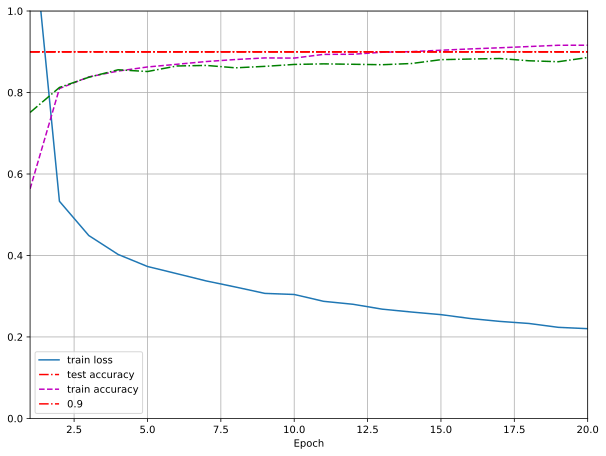

In [20]:
epochs = 20 # Number of epochs
acc, test_acc, loss = train_ch3(net, train_iter, test_iter, loss, epochs, optimizer)

print("Training accuracy: ", acc)
print("Test accuracy: ", test_acc)
print("Loss: ", loss)

In [21]:
#########################################################################
                              # TESTS #
#########################################################################

# Test(1) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.01) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 64
# output6 = 32
# output7 = 16
# output8 = 128
# output9 = 64
# output10 = 32
# classes = 10

# Training accuracy:  0.09968333333333333
# Test accuracy:  0.1
# Loss:  2.3038447249094647

#########################################################################

# Test(2) with 1 block 2 MLP - Optimizer RAdam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 250
# output3 = 200
# output4 = 49
# output5 = 150
# output6 = 100
# classes = 10

# Training accuracy:  0.9010333333333334
# Test accuracy:  0.8635
# Loss:  0.2654045897960663

#########################################################################

# Test(3) with 2 blocks 4 MLP - Optimizer Adam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 250
# output3 = 200
# output4 = 49
# output5 = 150
# output6 = 125
# output7 = 100
# output8 = 200
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.9807
# Test accuracy:  0.8777
# Loss:  0.051720261373122536

#########################################################################

# Test(4) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 250
# output3 = 200
# output4 = 49
# output5 = 150
# output6 = 125
# output7 = 100
# output8 = 200
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.97885
# Test accuracy:  0.8772
# Loss:  0.05563685638507207

#########################################################################

# Test(5) with 1 block 2 MLP - Optimizer Adam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 64
# output6 = 32
# classes = 10

# Training accuracy:  0.8994166666666666
# Test accuracy:  0.8705
# Loss:  0.2714559963067373

#########################################################################

# Test(6) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 64
# output6 = 32
# output7 = 16
# output8 = 128
# output9 = 64
# output10 = 32
# classes = 10

# Training accuracy:  0.9633833333333334
# Test accuracy:  0.8786 
# Loss:  0.09651933071215947

#########################################################################

# Test(7) with 1 block 2 MLP - Optimizer Adam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 128
# output6 = 64
# classes = 10

# Training accuracy:  0.9023
# Test accuracy:  0.8704
# Loss:  0.2636097701470057

#########################################################################

# Test(8) with 1 block 2 MLP - Optimizer RAdam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 260
# output3 = 130
# output4 = 49
# output5 = 68
# output6 = 35
# classes = 10

# Training accuracy:  0.8994666666666666
# Test accuracy:  0.8766
# Loss:  0.27412041379610697

#########################################################################

# Test(9) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.001) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 80
# output6 = 60
# output7 = 32
# output8 = 128
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.9704166666666667
# Test accuracy:  0.8769
# Loss:  0.07933524109522502

#########################################################################

# Test(10) with 1 block 2 MLP - Optimizer SGD (lr=0.01) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 260
# output3 = 130
# output4 = 49
# output5 = 68
# output6 = 35
# classes = 10

# Training accuracy:  0.8894666666666666
# Test accuracy:  0.8596
# Loss:  0.24412041379610697

#########################################################################

# Test(11) with 3 blocks 6 MLP - Optimizer Adam (lr=0.001) - Epochs = 60

# output1 = 49
# output2 = 250
# output3 = 200
# output4 = 49
# output5 = 150
# output6 = 125
# output7 = 100
# output8 = 200
# output9 = 100
# output10 = 50
# output11 = 128
# output12 = 80
# output13 = 200
# output14 = 50
# classes = 10

# Training accuracy:  0.8604166666666667
# Test accuracy:  0.8369
# Loss:  0.29933524109522502

#########################################################################

# Test(12) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.002) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 80
# output6 = 60
# output7 = 32
# output8 = 128
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.9716166666666667
# Test accuracy:  0.8807
# Loss:  0.07608278355995814

#########################################################################

# Test(13) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.002) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 100
# output6 = 80
# output7 = 64
# output8 = 128
# output9 = 80
# output10 = 60
# classes = 10

# Training accuracy:  0.9708666666666667
# Test accuracy:  0.8777
# Loss:  0.07748164043823878

#########################################################################

# Test(14) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.003) - Epochs = 60

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 80
# output6 = 60
# output7 = 32
# output8 = 128
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.9456
# Test accuracy:  0.8835
# Loss:  0.14226441016197205

#########################################################################

# Test(15) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.002) - Epochs = 30

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 80
# output6 = 60
# output7 = 32
# output8 = 128
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.9451166666666667
# Test accuracy:  0.8812
# Loss:  0.1439824555317561

#########################################################################

# Test(15) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.001) - Epochs = 30

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 80
# output6 = 60
# output7 = 32
# output8 = 128
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.9393166666666667
# Test accuracy:  0.8846
# Loss:  0.15946664481163025

#########################################################################

# Test(16) with 2 blocks 4 MLP - Optimizer RAdam (lr=0.001) - Epochs = 20

# patch size = 16

# output1 = 49
# output2 = 256
# output3 = 128
# output4 = 49
# output5 = 80
# output6 = 60
# output7 = 32
# output8 = 128
# output9 = 100
# output10 = 50
# classes = 10

# Training accuracy:  0.9160833333333334
# Test accuracy:  0.8859
# Loss:  0.22032673864364624

#########################################################################